In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scvelo as scv
import scanpy as sc
import scvi
import torch

import scprotvelo
from scprotvelo._utils import add_fits_branches
from scprotvelo._plotting import plot_phase_portraits
from scprotvelo._velocity_graph import velocity_graph

import warnings
warnings.filterwarnings('ignore') 

# Protein velocity inference with scProtVelo

## Data Loading

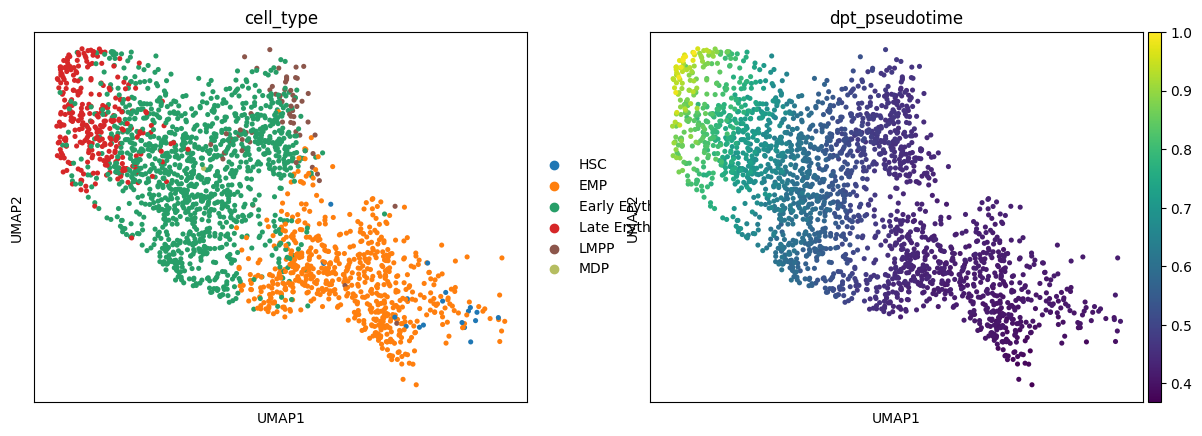

In [2]:
DATA_DIR = '/home/icb/sabrina.richter/git/scprotvelo/data/data_paired/'

adata = sc.read_h5ad(f"{DATA_DIR}paired_adata_Eryth_all_genes.h5ad")

sc.pl.umap(adata, color=['cell_type', 'dpt_pseudotime'])

In [3]:
adata.shape

(2212, 1039)

In [4]:
adata_train = adata

## Model Training

In [5]:
torch.manual_seed(0)
scvi.settings.seed = 0

scprotvelo.scProtVelo.setup_anndata(
    adata_train,
    protein_layer="protein",
    rna_layer="rna",
)

# to pretrain switch_time but keeping states at initial values
vae = scprotvelo.scProtVelo(
    adata_train, 
    kl_scaling=1000,
    penalty_scale=1000.,  
    kl_z_scaling=1000,
    kl_ss_scaling=1000, 
    shared_time=False,
    flexible_switch_time=False,
)
vae.train(
    max_epochs=100,
    early_stopping=True,
)

vae.module.penalty_scale = 0.
vae.module.kl_ss_scaling = .1
vae.module.kl_scaling = .01
vae.module.kl_z_scaling = 0.001

vae.train(
    max_epochs=2000,
    early_stopping=True,
    early_stopping_patience=70,
)

add_fits_branches(adata_train, vae)

[rank: 0] Seed set to 0


INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 46/100:  46%|████▌     | 46/100 [00:28<00:33,  1.61it/s, v_num=1, train_loss_step=4.92e+5, train_loss_epoch=5.18e+5]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Monitored metric elbo_validation did not improve in the last 45 records. Best score: 703.627. Signaling Trainer to stop.
Epoch 1378/2000:  69%|██████▉   | 1378/2000 [05:22<02:25,  4.27it/s, v_num=1, train_loss_step=195, train_loss_epoch=200]  
Monitored metric elbo_validation did not improve in the last 70 records. Best score: 2.009. Signaling Trainer to stop.


## Evaluation

In [6]:
quantile02 = adata_train.obs['dpt_pseudotime'].quantile(.2)
early = adata_train[adata_train.obs['dpt_pseudotime'] < quantile02].layers['rna'].mean(axis=0)

quantile08 = adata_train.obs['dpt_pseudotime'].quantile(.8)
late = adata_train[adata_train.obs['dpt_pseudotime'] > quantile08].layers['rna'].mean(axis=0)

up = np.array(late - early) > 0

adata_train.var['up_reg'] = up

adata_train.var['regulation'] = 'down'
adata_train.var.loc[adata_train.var['up_reg'] == 1, 'regulation'] = 'up'

adata_train.var['regulation_pred'] = 'down'
adata_train.var.loc[adata_train.var['state'] == 0, 'regulation_pred'] = 'up'

pd.crosstab(adata_train.var['regulation'], adata_train.var['regulation_pred'])

adata_train.var['correct'] = adata_train.var['regulation_pred'] == adata_train.var['regulation']

In [7]:
adata_train_full = adata_train.copy()

accuracy reaching 73.08% within the top 26 genes


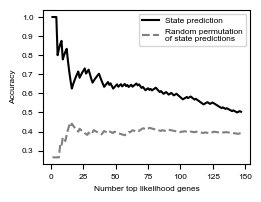

In [8]:
prob_down = np.mean(adata_train.var['state'])

de_genes = sc.read_h5ad(f"{DATA_DIR}paired_adata_Eryth_de_genes.h5ad").var_names
adata_train = adata_train[:, de_genes].copy()

# model performance
argind = np.argsort(adata_train.var['fit_likelihood'])[::-1]
sorted_acc = adata_train.var['correct'][argind]
cumfrac = np.cumsum(sorted_acc) / (np.arange(len(sorted_acc)) + 1)

# performance of random permutation
sorted_up = (adata_train.var['regulation'] == 'up')[argind]
cumfrac_perm = np.cumsum(sorted_up) / (np.arange(len(sorted_up)) + 1) # frac upregulated
cumfrac_perm = cumfrac_perm * (1-prob_down) + (1-cumfrac_perm) * prob_down

max = np.max(cumfrac[15:])
argmax = np.argmax(cumfrac[15:]) + 16
print(f'accuracy reaching {max*100:.2f}% within the top {argmax} genes')

with plt.rc_context({'font.family': 'Arial', 'font.size': 6}):
    fig, ax = plt.subplots(figsize=(2.6, 2))

    plt.plot((np.arange(len(sorted_acc)) + 1), cumfrac, label='State prediction', color='black')
    plt.plot((np.arange(len(sorted_up)) + 1), cumfrac_perm, label='Random permutation\nof state predictions', color='gray', linestyle='--')

    plt.xlabel('Number top likelihood genes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    plt.savefig('figures/direction.pdf')
    plt.show()

adata_train = adata_train_full.copy()

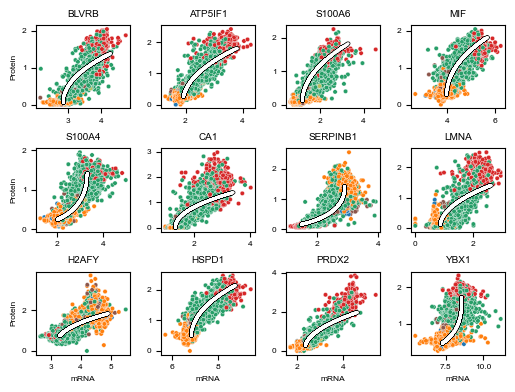

In [9]:
# top couple of genes

genes = list(adata_train.var['fit_likelihood'].sort_values(ascending=False).index)[:12]

with plt.rc_context({'font.family': 'Arial', 'font.size': 6}):
    plot_phase_portraits(
        adata_train,
        genes=genes,
        n_cols=4,
        rna_layer='rna', 
        protein_layer='protein',
        figsize=(1.3, 1.3),
        save='figures/phase_portraits_prot.pdf'
    )

computing velocity graph (using 1/112 cores)


  0%|          | 0/2212 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/stream_plot_prot.pdf


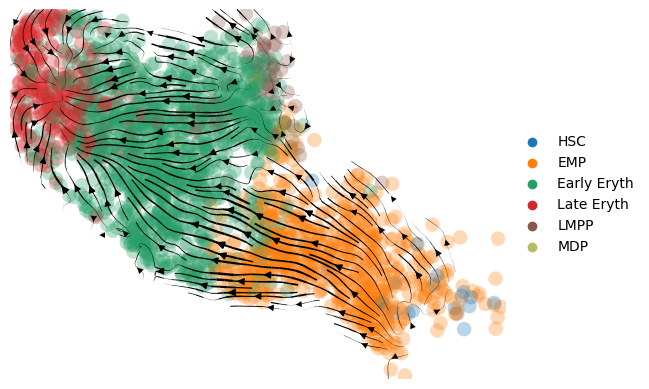

In [10]:
genes = list(adata_train.var['fit_likelihood'].sort_values(ascending=False).index)[:100]
adata2 = adata_train[:, genes].copy()

velocity_graph(adata2, xkey='protein')

scv.pl.velocity_embedding_stream(
    adata2, 
    color='cell_type', 
    basis='umap',
    title='',
    legend_loc='right_margin',
    save='figures/stream_plot_prot.pdf',
)

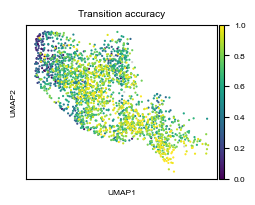

In [11]:
adata = adata2

velocity_graph = adata.uns['velocity_graph'].toarray() # rows=cells, cols=neighbors, values: positive if cell moves towards neighbor
dpt_diff = (adata.obs['dpt_pseudotime'][:, None] - adata.obs['dpt_pseudotime'].values).T # positive entry: pseudotime in column cell is higher than pseudotime in row cell
dpt_diff[velocity_graph == 0] = np.nan

is_positive = (dpt_diff * velocity_graph) > 0  # change in pseudotime agrees with direction of movement
is_not_nan = (dpt_diff * velocity_graph) == (dpt_diff * velocity_graph)

positive_counts = is_positive.sum(axis=1)
not_nan_counts = is_not_nan.sum(axis=1)
fraction_positive = positive_counts / not_nan_counts

adata.obs['Transition accuracy'] = fraction_positive # fraction of neighbors in velocity graph where direction of change agrees with change in pseudotime

with plt.rc_context({'font.family': 'Arial', 'font.size': 6, 'figure.figsize': (2.7, 2)}):
    sc.pl.umap(adata, color=['Transition accuracy'], vmin=0, vmax=1, s=10, save='_accuracy_scprotvelo.pdf')

In [12]:
pd.DataFrame(fraction_positive).to_csv('tmp/fraction_positive.csv', index=True)